<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 02: Min-P vs Top-P 探索

在自然语言生成领域，采样策略的选择对生成文本的质量和多样性影响深远。本文将探讨一种新兴的采样方法——最小 P 采样（Min-P Sampling），并与广泛使用的 Top-P（核）采样进行对比实验。

通过直观的代码示例和深入分析，我们希望帮助读者理解这两种方法的原理与差异，特别关注它们在 Qwen3 4B 模型上的表现。

## 1. Top-P 采样实现

Top-P 采样从概率分布中选择概率累积和超过阈值 p 的最小 token 集合，然后从这个集合中重新归一化概率并采样。这种方法确保只考虑概率较高的 token，同时保持一定的多样性。

数学表达式为：$V_{\text{Top-P}} = \{v_i \in V \mid \sum_{j=1}^{i} p(v_j) \geq p\}$，其中 $V$ 是按概率降序排列的词汇表。

因此，该采样方法能动态适应不同分布的“长尾”特性，保证“核”内累积概率始终接近p。

In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F


def top_p_sampling(logits: torch.Tensor, p: float = 0.9) -> torch.Tensor:
    """
    对 logits 做 top-p（nucleus）采样，返回采样得到的 token 索引。

    参数:
        logits: Tensor, 形状 (vocab_size,) 或 (batch_size, vocab_size)
        p: 累积概率阈值

    返回:
        如果是一维输入 (vocab_size,) 返回一个 scalar 的 token id (long Tensor of size 1)；
        如果是二维输入 (batch_size, vocab_size) 返回形状 (batch_size,) 的 token id Tensor。
    """
    # 1. softmax 得到概率
    probs = F.softmax(logits, dim=-1)

    # 2. 排序
    sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

    # 3. 标记要移除的 token（那些 cumulative > p 的）
    # 保证至少保留一个 token
    sorted_indices_to_remove = cumulative_probs > p
    # Shift right so that the token which makes cumulative exceed p is also removed
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = False

    # 4. 在原始 probs 上将这些 token 的概率置 0
    # 举例处理 batch 和 non‐batch
    if probs.dim() == 1:
        # 非 batch 情况
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[indices_to_remove] = 0.0
    else:
        # batch 情况
        batch_size, vocab_size = probs.shape
        mask = torch.zeros_like(probs, dtype=torch.bool)
        # 对每一行 batch 做
        for i in range(batch_size):
            idx_to_remove = sorted_indices[i][sorted_indices_to_remove[i]]
            mask[i, idx_to_remove] = True
        probs = probs.masked_fill(mask, 0.0)

    # 5. 重新归一化剩下的概率
    probs = probs / probs.sum(dim=-1, keepdim=True)

    # 6. 按新的分布采样
    # 如果是 batch，结果是 (batch_size,1)，然后 squeeze 成 (batch_size,)
    next_tokens = torch.multinomial(probs, num_samples=1)
    next_tokens = next_tokens.squeeze(-1)

    return next_tokens

/home/yswang/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Min-P 采样实现

Min-P 采样是 Top-P 采样的变体，它可以动态的根据模型对于下一个token的置信度来调整截断阈值而不是累积概率阈值。具体来说，它保留所有概率大于一个与最可能token概率 $p_{\text{max}}$ 成比例的值 $p_{\text{min}} = p_{\text{max}} * \alpha$ 的 token，然后从这些 token 中采样。这种方法提供了一种更直接的概率阈值控制方式。

数学表达式为：$V_{\text{min-p}} = \{v_i \in V \mid p(v_i) \geq p_{\text{min}}\}$

In [2]:
def min_p_sampling(logits: torch.Tensor, base_min_ratio: float = 0.05) -> int:
    """
    实现接近研究中 Min-p Sampling 的策略。

    参数:
        logits: 一维 tensor (vocab_size,) 表示模型输出的 logits
        base_min_ratio: 基础比例，例如 0.05，表示最低保留概率 = p_max * base_min_ratio

    返回:
        采样得到的 token 索引 （Python 整数）
    """
    probs = F.softmax(logits, dim=-1)
    # 找到最大概率
    p_max, _ = torch.max(probs, dim=-1)
    # 动态最小阈值 = p_max * base_min_ratio
    min_threshold = (p_max * base_min_ratio).item()
    # 过滤掉概率低于阈值的 token
    mask = probs < min_threshold
    probs = probs.clone()
    probs[mask] = 0.0
    # 保证至少保留一个 token：如果所有被过滤，则只保留最可能的那个
    if probs.sum().item() == 0.0:
        # 找到最大概率 token
        _, idx = torch.max(F.softmax(logits, dim=-1), dim=-1)
        probs.zero_()
        probs[idx] = 1.0
    # 归一化
    probs = probs / probs.sum()
    # 采样
    next_token = torch.multinomial(probs, num_samples=1)
    return next_token.item()

## 3. 实验设置

为了对比这两种采样策略在现代化模型上的效果，我们选择使用 Qwen3 4B 模型进行实验。这个模型在参数量和性能之间取得了良好平衡，适合进行采样策略的对比研究。

In [3]:


# 加载 Qwen3 4B 模型和分词器
model_name = "Qwen/Qwen3-4B-Instruct-2507"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# 设置填充 token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 将模型设置为评估模式
model.eval()

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [01:40<00:00, 33.53s/it]


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2560)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2560, out_features=4096, bias=False)
          (k_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2560, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=2560, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (up_proj): Linear(in_features=2560, out_features=9728, bias=False)
          (down_proj): Linear(in_features=9728, out_features=2560, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2560,), eps=1e-06)
        (post_attention_layernorm): Qwe

## 4. 文本生成

我们编写一个通用的文本生成函数，它可以接受不同的采样策略，并在 Qwen3 4B 模型上进行文本生成。

In [4]:
def generate_text(prompt, sampling_function, sampling_param, max_length=50):
    """
    使用指定的采样策略生成文本
    
    参数:
        prompt: 输入文本提示
        sampling_function: 采样函数
        sampling_param: 采样参数
        max_length: 生成的最大长度
        
    返回:
        生成的文本
    """
    # 编码输入文本
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    
    # 存储生成的 token
    generated = input_ids
    
    # 使用 no_grad 避免计算梯度
    with torch.no_grad():
        for _ in range(max_length):
            # 获取模型输出
            outputs = model(generated)
            next_token_logits = outputs.logits[:, -1, :]
            
            # 使用指定的采样策略获取下一个 token
            next_token = sampling_function(next_token_logits, sampling_param)
            
            # 将新 token 添加到已生成序列中
            generated = torch.cat([generated, torch.tensor([[next_token]], device=model.device)], dim=-1)
            
            # 如果生成了结束 token，停止生成
            if next_token == tokenizer.eos_token_id:
                break
    
    # 解码生成的文本
    return tokenizer.decode(generated[0], skip_special_tokens=True)

## 5. 对比实验

现在我们来对比两种采样策略在不同参数下的文本生成效果。首先定义一个测试函数来批量生成文本。

In [5]:
def compare_sampling_strategies(prompt, top_p_values, min_p_values):
    """
    对比不同参数下的采样策略效果
    
    参数:
        prompt: 输入提示
        top_p_values: 要测试的 Top-P 值列表
        min_p_values: 要测试的 min-p 值列表
    """
    print(f"输入提示: '{prompt}'\n")
    
    # 测试 Top-P 采样
    print("Top-P 采样结果:")
    for p in top_p_values:
        generated_text = generate_text(prompt, top_p_sampling, p)
        print(f"p={p}: {generated_text[len(prompt):]}")
    
    print("\n" + "="*50 + "\n")
    
    # 测试 Min-P 采样
    print("Min-P 采样结果:")
    for min_prob in min_p_values:
        generated_text = generate_text(prompt, min_p_sampling, min_prob)
        print(f"min_prob={min_prob}: {generated_text[len(prompt):]}")

使用相同的提示文本，我们观察两种采样策略在 Qwen3 4B 模型上的生成效果。选择适当的参数范围对于观察差异至关重要。

In [6]:
# 设置测试参数
test_prompt = "人工智能的未来发展将"
top_p_values = [0.5, 0.8, 0.9]
min_p_values = [0.01, 0.05, 0.1]

# 运行对比实验
compare_sampling_strategies(test_prompt, top_p_values, min_p_values)

输入提示: '人工智能的未来发展将'

Top-P 采样结果:


p=0.5: 如何影响人类社会？

人工智能（AI）的未来发展将对人类社会产生深远而广泛的影响，涵盖经济、社会结构、伦理、教育、医疗、就业、安全等多个领域。以下是几个关键方面的具体影响：

---

### 1
p=0.8: 对社会产生深远影响。然而，这一进程并非一帆风顺，我们必须警惕潜在的威胁。例如，当人工智能被用于歧视性目的时，它可能加剧社会不平等，损害少数群体的权益。此外，如果人工智能
p=0.9: 对社会产生深远影响。例如，它可能推动经济增长，提高生产效率，改善医疗、教育等公共服务，同时也会带来就业结构的变化、隐私泄露风险和伦理问题。因此，发展人工智能必须坚持安全、可控、可持续的原则


Min-P 采样结果:
min_prob=0.01: 主要聚焦于以下哪些方面？
A. 人工智能技术的集成化与融合
B. 多模态技术的突破
C. 大模型的演进
D. 人工智能的深度应用与落地
答案:
AB
min_prob=0.05: 带来哪些挑战？

人工智能的未来发展将带来诸多挑战，主要包括以下几个方面：

1. **伦理与道德问题**  
   - **偏见与歧视**：AI系统可能继承或放大训练数据中的偏见，导致不公平的决策
min_prob=0.1: 如何影响人类社会？

人工智能（AI）的快速发展正在深刻地改变人类社会的方方面面，其未来的发展将对经济、教育、医疗、就业、伦理、安全等多个领域产生深远影响。以下是人工智能未来发展可能带来的主要影响：




从生成结果中，我们可以观察到一些有趣的现象。较低的 p 值（如 0.5）在 Top-P 采样中会导致更保守的生成，只考虑概率最高的几个 token，而较高的 p 值（如 0.9）会允许更多样化的生成，但可能包含一些不太相关的 token。生成结果的质量和多样性对 p 值非常敏感，这反映了 Top-P 采样的动态特性。

对于 Min-P 采样，较低的最小概率阈值（如 0.01）会保留更多 token，导致更多样化的生成，而较高的最小概率阈值（如 0.1）会更严格，只保留概率较高的 token。相对于 Top-P，Min-P 提供了一种更直接的概率阈值控制方式，使生成过程更加稳定和可预测。

## 6. 可视化分析

为了更直观地理解两种方法的差异，我们可以可视化它们对概率分布的过滤效果。

/home/yswang/ncu_tmp/ipykernel_3345637/2132065162.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/yswang/ncu_tmp/ipykernel_3345637/2132065162.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./images/sampling_effect.png")  # 保存到当前目录


图已保存到 sampling_effect.png


/home/yswang/miniforge3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


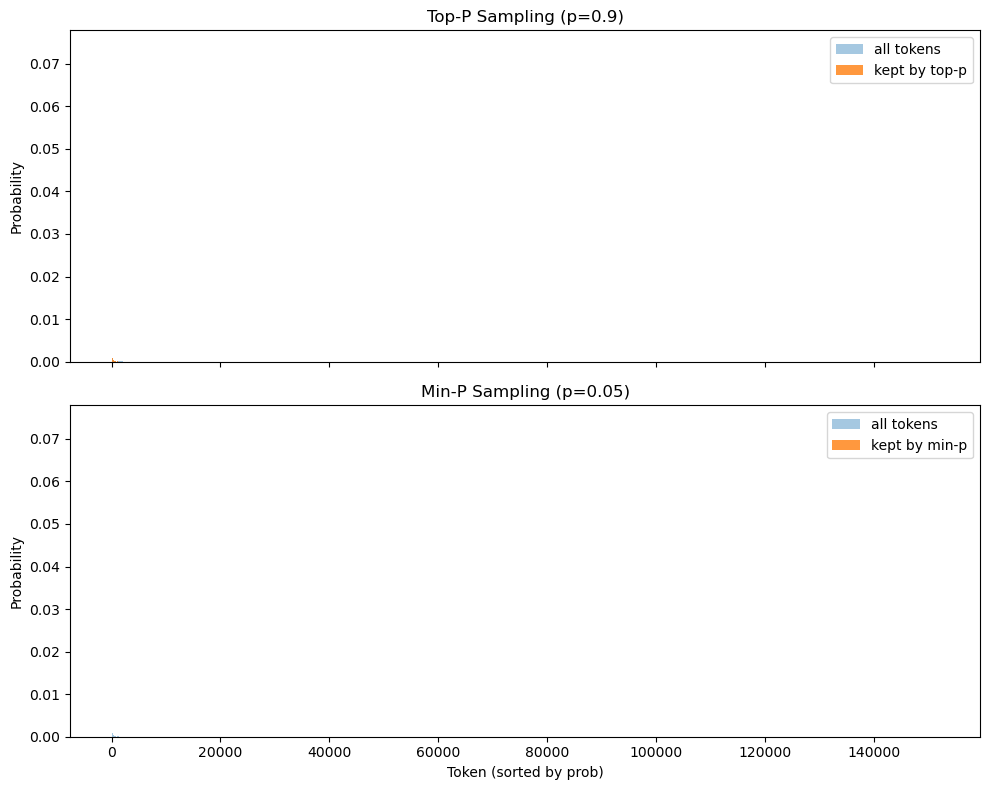

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_sampling_effect(logits, top_p=0.9, min_p=0.05):
    """
    可视化 top-p 和 min-p 对概率分布的截断效果。
    
    参数:
        logits: 1D 或 2D 的 logits（如果是 2D，形状 (vocab_size,) 或 (1, vocab_size)）
        top_p:  top-p 截断阈值
        min_p:  min-p 截断阈值
    """
    # 保证是一维
    if logits.dim() > 1:
        logits = logits.squeeze(0)
    
    # 归一化成概率
    probs = torch.softmax(logits, dim=-1)

    # 概率从大到小排序
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

    # top-p & min-p 掩码（都是 bool Tensor）
    top_p_mask = cumulative_probs <= top_p
    min_p_mask = sorted_probs >= min_p

    # 转 numpy，方便 matplotlib + 布尔索引
    probs_np = sorted_probs.cpu().numpy()
    top_p_mask_np = top_p_mask.cpu().numpy()
    min_p_mask_np = min_p_mask.cpu().numpy()
    x = np.arange(len(probs_np))  # 索引 [0, 1, 2, ..., vocab_size-1]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # ---- Top-P 子图 ----
    ax1.bar(x, probs_np, alpha=0.4, label='all tokens')
    ax1.bar(x[top_p_mask_np], probs_np[top_p_mask_np], alpha=0.8, label='kept by top-p')
    ax1.set_title(f'Top-P Sampling (p={top_p})')
    ax1.set_ylabel('Probability')
    ax1.legend()

    # ---- Min-P 子图 ----
    ax2.bar(x, probs_np, alpha=0.4, label='all tokens')
    ax2.bar(x[min_p_mask_np], probs_np[min_p_mask_np], alpha=0.8, label='kept by min-p')
    ax2.set_title(f'Min-P Sampling (p={min_p})')
    ax2.set_xlabel('Token (sorted by prob)')
    ax2.set_ylabel('Probability')
    ax2.legend()

    plt.tight_layout()
    # plt.show()  
    plt.savefig("./images/sampling_effect.png")  # 保存到当前目录
    print("图已保存到 sampling_effect.png")



# 获取一个示例 logits 分布
with torch.no_grad():
    test_input = tokenizer.encode("人工智能的", return_tensors="pt").to(model.device)
    outputs = model(test_input)
    sample_logits = outputs.logits[:, -1, :].squeeze().cpu()

# 可视化
visualize_sampling_effect(sample_logits, top_p=0.9, min_p=0.05)

通过可视化分析，我们可以清楚地看到两种采样方法如何过滤概率分布。Top-P 采样保留累积概率达到阈值的最少 token 集合，而 Min-P 采样保留所有概率超过最小阈值的 token。这种差异在实际生成过程中会导致不同的文本质量和多样性特征。

## 7. 总结与思考

从计算效率角度来看，两种方法在复杂度上相似，都需要对概率进行排序和过滤。在实际应用中，最佳采样策略和参数往往需要根据具体任务和模型进行调优。

Min-P 采样作为 Top-P 采样的新兴变体，提供了另一种控制文本生成质量的方式。随着大语言模型技术的不断发展，采样策略的研究也将继续深入，为自然语言生成任务提供更多灵活性和控制能力。